In [ ]:
import os
from pathlib import Path
import numpy as np
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import mne
from scipy import signal

file_path: Path = Path(os.getcwd()).resolve()
eeg_folder: Path = file_path / "eeg_files"


In [72]:
eeg_data: dict[str, np.ndarray] = {}

for file in eeg_folder.iterdir():
    if file.is_file() and file.suffix == ".txt" and "sleep" in file.name:
        data = np.loadtxt(file)                                # Carga cada array
        name = file.stem.replace("input_nonepi_", "")          # e.g. "sleep_1"
        eeg_data[name] = data

# 2. Ordenar los canales para garantizar consistencia
channel_names = sorted(eeg_data.keys())                     # ['sleep_1','sleep_2','sleep_3']

# 3. Apilar verticalmente en un array 2D (n_canales, n_muestras)
data_2d = np.vstack([eeg_data[ch] for ch in channel_names])  # Utiliza np.vstack :contentReference[oaicite:3]{index=3}

# 4. Crear el objeto Info
sfreq = 1024.0                                             # Frecuencia de muestreo en Hz (ajusta si es distinto)
ch_types = ['eeg'] * len(channel_names)
info = mne.create_info(ch_names=channel_names,             # Nombres de canal
                       sfreq=sfreq,
                       ch_types=ch_types)                  # create_info :contentReference[oaicite:4]{index=4}

# 5. Construir el RawArray
raw = mne.io.RawArray(data_2d, info)                      # RawArray :contentReference[oaicite:5]{index=5}
print(raw)
print(raw.info)

Creating RawArray with float64 data, n_channels=3, n_times=61440
    Range : 0 ... 61439 =      0.000 ...    59.999 secs
Ready.
<RawArray | 3 x 61440 (60.0 s), ~1.4 MiB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: sleep_1, sleep_2, sleep_3
 chs: 3 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 3
 projs: []
 sfreq: 1024.0 Hz
>


Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_10164/2746531926.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot(picks="data", exclude="bads", amplitude=False)
/home/juan-luis/git-repositories/TFM-BigData/.venv-noise/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


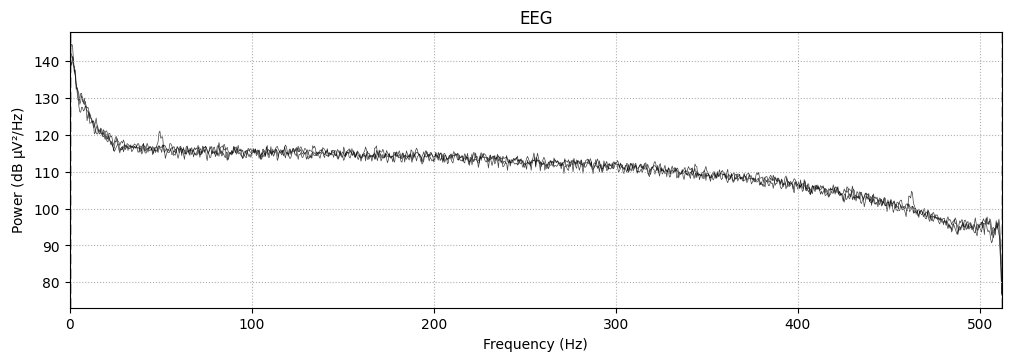

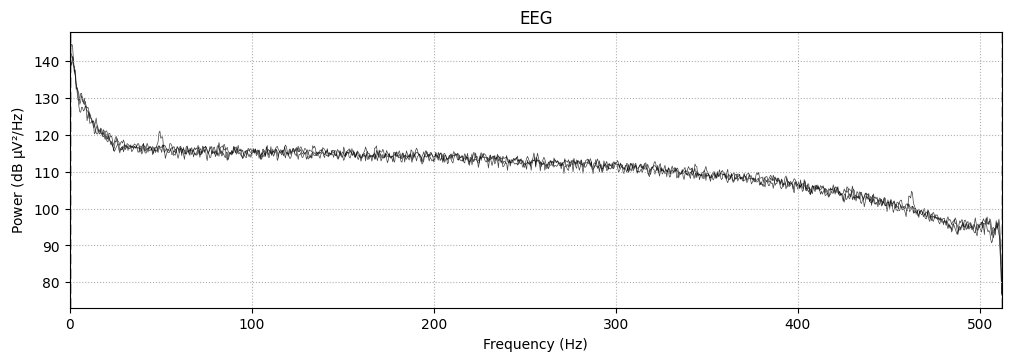

In [73]:
raw.compute_psd().plot(picks="data", exclude="bads", amplitude=False)

{'sleep_2': array([37.62981613, 37.62981613, 39.97830326, ..., 17.18915265,
        22.61563862, 22.61563862]),
 'sleep_3': array([56.52457949, 56.52457949, 47.16688997, ..., 17.27341761,
         2.27697539,  2.27697539]),
 'sleep_1': array([18.41265638, 18.41265638, 25.46828019, ..., 25.07583396,
        42.16823282, 42.16823282])}